In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import pandas as pd
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
from PIL import Image
from glob import glob
import wandb
import re
from adjustText import adjust_text
import seaborn as sns
import nibabel as nib
import scipy
import statannot
import argparse
import sys
#print(glob('../../*'))
sys.path.append('../../modified_medsam_repo')
from MedSAM_HCP.utils_hcp import *
from MedSAM_HCP.dataset import MRIDataset, MRIDatasetForPooled, MRIDataset_Imgs, load_datasets, LabelConverter
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn


/gpfs/home/kn2347/.conda/envs/medsam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_model(model_type, model_path, num_classes):
    result = torch.load(model_path)
    try:
        if 'model' in result.keys():
            splits = model_path.split('/')
            new_path = os.path.join('/'.join(splits[:-1]), f'{splits[-1].split(".pth")[0]}_sam_readable.pth')
            print(f'model path converted to sam readable format and saved to {new_path}')

            result = result['model']

            # now remove the "module." prefix
            result_dict = {}
            for k,v in result.items():
                key_splits = k.split('.')
                assert key_splits[0] == 'module'
                new_k = '.'.join(key_splits[1:])
                result_dict[new_k] = v

            torch.save(result_dict, new_path)
            model_path = new_path

    except (AttributeError):
        # already in the correct format
        print('model path in readable format already')

    if model_type == 'multitask_unprompted':
        model = build_sam_vit_b_multiclass(num_classes, checkpoint=model_path).to('cuda')
    elif model_type == 'pooltask_yolov7_prompted':
        model = build_sam_vit_b_multiclass(num_classes, checkpoint=model_path).to('cuda')
    elif model_type == 'singletask_unet':
        model = torch.load(model_path)
    else:
        # singletask model
        model = build_sam_vit_b_multiclass(3, checkpoint=model_path).to('cuda')

    model.eval()
    return model


In [3]:
df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')
label_converter = LabelConverter(df_hcp, df_desired)

In [4]:
#df_hcp = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_unet.csv', dtype={'id': str})
df_hcp = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/skull_stripped_hcp_experiment_10-24-24/skull_stripped_df_unet.csv', dtype={'id': str})
df_brats = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/registered_brats_normalized_expt_10-29-24/inputs/brats_001_registered/path_df_singletask_unet.csv')

In [5]:
label = 1
preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')
model_path = glob(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_retrain_all_labels_9-9-24/training/{label}/*-best_model.pth')[0]
model = load_model('singletask_unet', model_path, num_classes=1)
dataset_hcp = MRIDataset_Imgs(df_hcp, label_id = label, bbox_shift=0, label_converter = label_converter, NUM_CLASSES=2, as_one_hot=True, pool_labels=False, preprocess_fn=preprocess_input)
dataset_brats = MRIDataset_Imgs(df_brats, label_id = label, bbox_shift=0, label_converter = label_converter, NUM_CLASSES=2, as_one_hot=True, pool_labels=False, preprocess_fn=preprocess_input)

model path in readable format already


In [13]:
brats_arr = nib.load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/registered_brats_normalized_expt_10-29-24/inputs/brats_001_registered/registered_t1.nii').get_fdata()
hcp_arr = nib.load('/gpfs/data/cbi/hcp/hcp_seg/data_orig/151425/mri/brainmask.mgz').get_fdata()
dicto = {'channel':[], 'dataset':[], 'value':[], 'slice':[]}

for sli in tqdm(range(256)):
    #vv = dataset_hcp[sli][0].numpy() # (3,256,256)
    vv = np.array(Image.open(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/skull_stripped_hcp_experiment_10-24-24/inputs/pngs/151425/151425_slice{sli}.png')).transpose((2,0,1))
    #vv = np.repeat(hcp_arr[:,sli,:][None,:,:], 3, axis=0)
    
    for chan in range(3):
        cont = vv[chan,:,:].flatten().tolist()
        dicto['value'].extend(cont)
        dicto['channel'].extend([chan] * len(cont))
        dicto['dataset'].extend(['hcp'] * len(cont))
        dicto['slice'].extend([sli] * len(cont))

    #vv = dataset_brats[sli][0].numpy()
    vv = np.array(Image.open(f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/registered_brats_normalized_expt_10-29-24/inputs/pngs/brats_001_registered/brats_001_registered_slice{sli}.png')).transpose((2,0,1))
    #vv = np.repeat(brats_arr[:,sli,:][None,:,:], 3, axis=0)

    for chan in range(3):
        cont = vv[chan,:,:].flatten().tolist()
        dicto['value'].extend(cont)
        dicto['channel'].extend([chan] * len(cont))
        dicto['dataset'].extend(['brats'] * len(cont))
        dicto['slice'].extend([sli] * len(cont))

df = pd.DataFrame(dicto)
df['value'] = df['value'].astype('uint8')
#sns.violinplot(df, x='channel', y='value', hue='dataset')

100%|██████████| 256/256 [00:04<00:00, 51.80it/s]


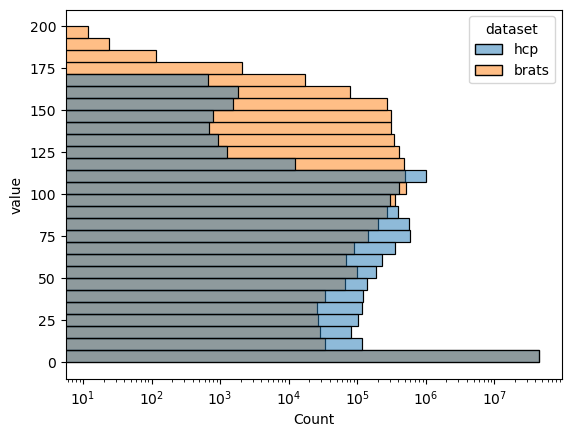

In [14]:
fig, axs = plt.subplots()
sns.histplot(df, y='value',hue = 'dataset', ax=axs)
axs.set_xscale('log')

In [15]:
summarizer = df.groupby(by=['slice', 'dataset']).aggregate('max').reset_index()

In [72]:
xy = summarizer.copy()
lister = []
for i, r in xy.iterrows():
    if r['dataset'] == 'brats':
        lister.append(r['value'])

for i, r in xy.iterrows():
    if r['dataset'] == 'brats':
        xy.loc[i, 'value'] = xy.loc[i, 'value'] / np.max(lister) * 135

<Axes: xlabel='slice', ylabel='value'>

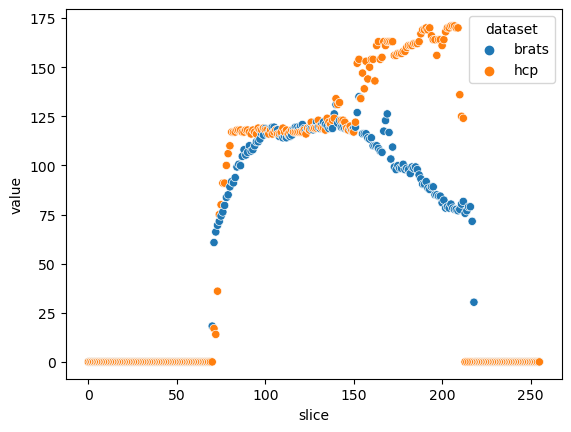

In [73]:
sns.scatterplot(xy, x='slice', y='value', hue='dataset')

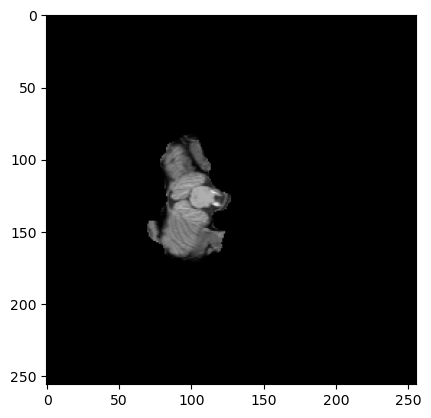

In [84]:
def viz_slice(ds, idx):
    arr = ds[idx][0].numpy().transpose((1,2,0))
    arr = (arr - arr.min(axis=(0,1))) / (arr.max(axis=(0,1)) - arr.min(axis=(0,1)))
    plt.imshow(arr)

viz_slice(dataset_hcp, 200)

In [ ]:
# what does the distribution look like for each individual slice?
# alternatively, what is the max value for each slice


fig, axs = plt.subplots()
sns.histplot(df, x='channel', y='value', hue='dataset', ax=axs)
axs.set_xscale('log')

<Axes: xlabel='Count', ylabel='value'>

In [ ]:
#df_brats.iloc[128,2]
df_hcp.iloc[128,2]

for id in df_hcp.id.unique():
    listo = []
    for i in range(256):
        npo = np.array(Image.open(f'/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/dir_structure_for_yolov7/train/images/{id}_slice{i}.png'))
        listo.append(npo.max())
    print(f'{id}: {np.max(listo)}')



In [89]:
pattern_brats = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/registered_brats_normalized_expt_10-29-24/inputs/pngs/brats_001_registered/brats_001_registered_slice*.png'
pattern_hcp = 
npo = np.array(Image.open())
print(preprocess_input(npo).max())


1.2805228758169933
